# **Individual Assingment**: Default Credit Cards Clients

A bank in you region want to build a model to predict credit card defaulters more accurately in order minimize money loss. For this task we have a set of data on default payments and demographic data to help us do our task. Data is comprised in the following CSV files:


**TRAINING**

**`train_customers.csv`**
 - `ID`: ID of each client
 - `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
 - `SEX`: Gender (1=male, 2=female)
 - `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 - `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
 - `AGE`: Age in years
 
**`train_series.csv`**
 - `ID`: ID of each client
 - `MONTH`: The month to wich data is refering
 - `PAY`: Repayment status in the corresponding month (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
 - `BILL_AMT`: Amount of bill statement in the corresponding month (NT dollar)
 - `PAY_AMT`: Amount of previous payment in the corresponding month (NT dollar)
 
**`train_target.csv`**
 - `DEFAULT_JULY`: Default payment in July (1=yes, 0=no)
 
 
**TEST** (For PART 3)
 - **`test_data.csv`**
 
**SUBMISSION** (For PART 3)
 - **`submission_features.csv`**
 
**BACKUP**
 - **`train_data.csv`**

Load all data and answer the following questions

## **A. DATA ENGINEERING (3 points)**

#### All imports

In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### **Question 1**

(2 points)

In [182]:
train_series = pd.read_csv("Data/train_series.csv")
train_series.head()

,ID,MONTH,PAY,BILL_AMT,PAY_AMT
0,9910,JUNE,0.0,76885.0,3500.0
1,9910,MAY,0.0,79106.0,4000.0
2,9910,APRIL,0.0,81231.0,3000.0
3,9910,MARCH,0.0,81983.0,3146.0
4,9910,FEBRUARY,0.0,83773.0,3260.0


In [183]:
train_series_pivot = train_series.pivot(index="ID", columns="MONTH", values=["PAY", "BILL_AMT", "PAY_AMT"])
train_series_pivot.head()

PAY                                   BILL_AMT                      \
MONTH APRIL FEBRUARY JANUARY JUNE MARCH  MAY     APRIL  FEBRUARY   JANUARY   
ID                                                                           
0       0.0     -1.0     0.0 -1.0   0.0  0.0   13600.0   44024.0   18697.0   
1       0.0      0.0     0.0  0.0   0.0  0.0   53169.0   50372.0   49470.0   
2       2.0      2.0     2.0  2.0   2.0  2.0  161487.0  168094.0  170922.0   
3      -2.0     -2.0    -2.0 -2.0  -2.0 -2.0       0.0       0.0       0.0   
4       0.0      0.0     0.0  0.0   0.0  0.0    9044.0    9417.0    9617.0   

                                    PAY_AMT                            \
MONTH      JUNE     MARCH       MAY   APRIL FEBRUARY  JANUARY    JUNE   
ID                                                                      
0       28991.0       0.0   24391.0     0.0    680.0  10000.0  1300.0   
1       75662.0   50875.0   70073.0  2000.0   1903.0   2006.0  3212.0   
2      155910.0  157577.0  158819.0     0.0   5500.0   1000.0  6800.0   
3       23570.0       0.0     735.0     0.0      0.0      0.0   742.0   
4        8214.0    9225.0    8034.0   331.0    356.0    330.0  1140.0   

                        
MONTH    MARCH     MAY  
ID                      
0      22373.0  1000.0  
1       1603.0  2106.0  
2      13000.0  6500.0  
3          0.0     0.0  
4        341.0  1150.0

In [184]:
train_series_pivot.columns = [f"{col}_{month}" for col, month in train_series_pivot.columns]
train_series_pivot.head()

,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY
ID,,,,,,,,,,,,,,,,,,
0,0.0,-1.0,0.0,-1.0,0.0,0.0,13600.0,44024.0,18697.0,28991.0,0.0,24391.0,0.0,680.0,10000.0,1300.0,22373.0,1000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,53169.0,50372.0,49470.0,75662.0,50875.0,70073.0,2000.0,1903.0,2006.0,3212.0,1603.0,2106.0
2,2.0,2.0,2.0,2.0,2.0,2.0,161487.0,168094.0,170922.0,155910.0,157577.0,158819.0,0.0,5500.0,1000.0,6800.0,13000.0,6500.0
3,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,23570.0,0.0,735.0,0.0,0.0,0.0,742.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,9044.0,9417.0,9617.0,8214.0,9225.0,8034.0,331.0,356.0,330.0,1140.0,341.0,1150.0


In [185]:
train_series_pivot = train_series_pivot.reset_index()
train_series_pivot.head()

,ID,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY
0,0,0.0,-1.0,0.0,-1.0,0.0,0.0,13600.0,44024.0,18697.0,28991.0,0.0,24391.0,0.0,680.0,10000.0,1300.0,22373.0,1000.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,53169.0,50372.0,49470.0,75662.0,50875.0,70073.0,2000.0,1903.0,2006.0,3212.0,1603.0,2106.0
2,2,2.0,2.0,2.0,2.0,2.0,2.0,161487.0,168094.0,170922.0,155910.0,157577.0,158819.0,0.0,5500.0,1000.0,6800.0,13000.0,6500.0
3,3,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,23570.0,0.0,735.0,0.0,0.0,0.0,742.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,9044.0,9417.0,9617.0,8214.0,9225.0,8034.0,331.0,356.0,330.0,1140.0,341.0,1150.0


### **Question 2**

(0.5 points)

In [186]:
train_customers = pd.read_csv("Data/train_customers.csv")
train_customers.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,9910,130000.0,2,2,1,27
1,15561,60000.0,2,3,1,48
2,23607,330000.0,2,1,2,44
3,6314,60000.0,2,2,2,24
4,27534,180000.0,2,1,2,33


In [187]:
train_customers = pd.merge(train_customers, train_series_pivot, on="ID")
train_customers.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,...,BILL_AMT_JANUARY,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY
0,9910,130000.0,2,2,1,27,0.0,0.0,0.0,0.0,...,85532.0,76885.0,81983.0,79106.0,3000.0,3260.0,3200.0,3500.0,3146.0,4000.0
1,15561,60000.0,2,3,1,48,-1.0,-1.0,-1.0,-1.0,...,2431.0,4823.0,4377.0,5471.0,4377.0,2431.0,2120.0,5491.0,3918.0,9683.0
2,23607,330000.0,2,1,2,44,2.0,0.0,0.0,0.0,...,268145.0,243621.0,257535.0,259517.0,9400.0,9766.0,9786.0,21400.0,9542.0,0.0
3,6314,60000.0,2,2,2,24,0.0,0.0,0.0,0.0,...,-2879.0,29832.0,15761.0,18628.0,1000.0,1329.0,41378.0,1538.0,118.0,1308.0
4,27534,180000.0,2,1,2,33,-1.0,-1.0,-1.0,-2.0,...,1118.0,4500.0,1500.0,2580.0,1500.0,1118.0,1331.0,2580.0,0.0,178.0


### **Question 3**

(0.5 points)

In [188]:
train_target = pd.read_csv("Data/train_target.csv")
train_target.head()

,ID,DEFAULT_JULY
0,9910,0
1,15561,1
2,23607,1
3,6314,0
4,27534,0


In [189]:
train_data = pd.merge(train_customers, train_target, on="ID")
train_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,...,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY
0,9910,130000.0,2,2,1,27,0.0,0.0,0.0,0.0,...,76885.0,81983.0,79106.0,3000.0,3260.0,3200.0,3500.0,3146.0,4000.0,0
1,15561,60000.0,2,3,1,48,-1.0,-1.0,-1.0,-1.0,...,4823.0,4377.0,5471.0,4377.0,2431.0,2120.0,5491.0,3918.0,9683.0,1
2,23607,330000.0,2,1,2,44,2.0,0.0,0.0,0.0,...,243621.0,257535.0,259517.0,9400.0,9766.0,9786.0,21400.0,9542.0,0.0,1
3,6314,60000.0,2,2,2,24,0.0,0.0,0.0,0.0,...,29832.0,15761.0,18628.0,1000.0,1329.0,41378.0,1538.0,118.0,1308.0,0
4,27534,180000.0,2,1,2,33,-1.0,-1.0,-1.0,-2.0,...,4500.0,1500.0,2580.0,1500.0,1118.0,1331.0,2580.0,0.0,178.0,0


In [305]:
train_data.to_csv('Patel_Radhika_A_train.csv')

## **B. EXPLORATORY DATA ANALYSIS (2 points)**

### **Question 1**

(0.5 points)

##### Graph plot

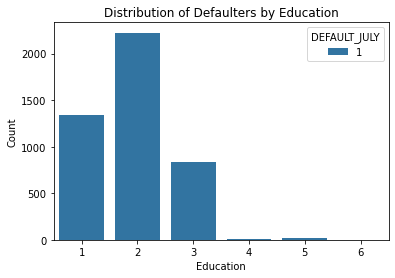

In [194]:
# Create the bar plot
df_defaulters = train_data[train_data["DEFAULT_JULY"] == 1]

sns.countplot(x="EDUCATION", hue="DEFAULT_JULY", data=df_defaulters)

# Add labels and title
plt.xlabel("Education")
plt.ylabel("Count")
plt.title("Distribution of Defaulters by Education")

# Show the plot
plt.show()

##### Insight: 
- The highest number of defaulters are customers with a college degree** (over 80% of all defaulters)**. This is interesting. This is because we assume that college graduates have higher incomes and are more likely to pay off their credit card debt. 

 - In addition, it is worth noting that the number of delinquents who graduated from high school is low** (less than 20% of all delinquents)**. One possible reason, although small in absolute terms, is that the credit limits given to these customers are very low relative to their income level and therefore the probability of default is very low. It could also be that the bank has fewer credit card holders that have only a high school education

### **Question 2**

(0.5 points)

##### Graph plot

In [113]:
train_data['LIMIT_BAL'].describe()

count      20000.000000
mean      167954.600000
std       129789.561234
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

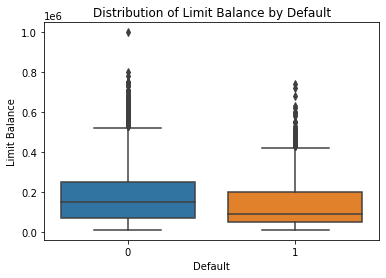

In [114]:
# Create the box plot
sns.boxplot(x="DEFAULT_JULY", y="LIMIT_BAL", data=train_data)

# Add labels and title
plt.xlabel("Default")
plt.ylabel("Limit Balance")
plt.title("Distribution of Limit Balance by Default")

# Show the plot
plt.show()

##### Insight: 
- The box of the defaulters is more dense than that of the people that do not default. The outliers for the default category are also less spread out than the non default category. 
- Furthermore the Q1, Q2, Q3 are all higher for non-defaulters than defaulter
- This means that usually the people with lower credit limits tend to default more. 
- However both the categories have many outliers

### **Question 3**

(1 point)

#### General Exploration

In [115]:
train_data.isnull().sum()

ID                   0
LIMIT_BAL            0
SEX                  0
EDUCATION            0
MARRIAGE             0
AGE                  0
PAY_APRIL            0
PAY_FEBRUARY         0
PAY_JANUARY          0
PAY_JUNE             0
PAY_MARCH            0
PAY_MAY              0
BILL_AMT_APRIL       0
BILL_AMT_FEBRUARY    0
BILL_AMT_JANUARY     0
BILL_AMT_JUNE        0
BILL_AMT_MARCH       0
BILL_AMT_MAY         0
PAY_AMT_APRIL        0
PAY_AMT_FEBRUARY     0
PAY_AMT_JANUARY      0
PAY_AMT_JUNE         0
PAY_AMT_MARCH        0
PAY_AMT_MAY          0
DEFAULT_JULY         0
dtype: int64

In [116]:
train_data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,...,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY
count,20000.00000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,2.000000e+04,20000.000000
mean,14940.65875,167954.600000,1.60580,1.853850,1.550050,35.494300,-0.16615,-0.269950,-0.290950,-0.017500,...,51455.534050,43453.546450,49415.425450,5336.185100,4826.740350,5063.527050,5732.43835,4903.173400,5.869932e+03,0.221000
std,8652.81960,129789.561234,0.48869,0.791847,0.522215,9.230733,1.19671,1.125718,1.145366,1.121453,...,74144.629562,64651.193334,71489.057991,18686.860416,15596.035022,16349.170961,16938.48685,16189.314581,2.326906e+04,0.414931
min,0.00000,10000.000000,1.00000,0.000000,0.000000,21.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-165580.000000,-170000.000000,-69777.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000
25%,7460.75000,50000.000000,1.00000,1.000000,1.000000,28.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,3581.000000,2400.000000,2962.500000,396.000000,290.750000,158.000000,999.75000,307.000000,8.345000e+02,0.000000
50%,14952.50000,140000.000000,2.00000,2.000000,2.000000,34.000000,0.00000,0.000000,0.000000,0.000000,...,22483.000000,19171.500000,21593.000000,1820.000000,1500.000000,1500.000000,2102.00000,1500.000000,2.011000e+03,0.000000
75%,22439.50000,240000.000000,2.00000,2.000000,2.000000,41.250000,0.00000,0.000000,0.000000,0.000000,...,67414.750000,54558.500000,64031.500000,4598.000000,4036.250000,4000.000000,5025.00000,4054.250000,5.000000e+03,0.000000
max,29999.00000,1000000.000000,2.00000,6.000000,3.000000,79.000000,8.00000,8.000000,8.000000,8.000000,...,964511.000000,891586.000000,983931.000000,896040.000000,426529.000000,443001.000000,873552.00000,621000.000000,1.684259e+06,1.000000


In [117]:
train_data.dtypes

ID                     int64
LIMIT_BAL            float64
SEX                    int64
EDUCATION              int64
MARRIAGE               int64
AGE                    int64
PAY_APRIL            float64
PAY_FEBRUARY         float64
PAY_JANUARY          float64
PAY_JUNE             float64
PAY_MARCH            float64
PAY_MAY              float64
BILL_AMT_APRIL       float64
BILL_AMT_FEBRUARY    float64
BILL_AMT_JANUARY     float64
BILL_AMT_JUNE        float64
BILL_AMT_MARCH       float64
BILL_AMT_MAY         float64
PAY_AMT_APRIL        float64
PAY_AMT_FEBRUARY     float64
PAY_AMT_JANUARY      float64
PAY_AMT_JUNE         float64
PAY_AMT_MARCH        float64
PAY_AMT_MAY          float64
DEFAULT_JULY           int64
dtype: object

#### Insights

##### Checking for values

In [118]:
categorical_variables = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = train_data[categorical_variables]


In [119]:
for col in df_cat:
    print(f"{col}:\n{df_cat[col].value_counts()}\n")

SEX:
2    12116
1     7884
Name: SEX, dtype: int64

EDUCATION:
2    9290
1    7085
3    3308
5     182
4      95
6      33
0       7
Name: EDUCATION, dtype: int64

MARRIAGE:
2    10605
1     9143
3      216
0       36
Name: MARRIAGE, dtype: int64



##### Insight: Both Education and Marriage have value 0 which is not signified as a category by the dataset.
- For Education, values that are 0(invalid) and 6(unknown) will be turned into 4 which is 'others'
- For Marriage, values that are 0(invalid) will be turned into 4 which is 'others'

In [120]:
#Cleaning Education 
train_data['EDUCATION']=np.where(train_data['EDUCATION'] == 6, 4, train_data['EDUCATION'])
train_data['EDUCATION']=np.where(train_data['EDUCATION'] == 0, 4, train_data['EDUCATION'])

In [121]:
#Cleaning Marriage
train_data['MARRIAGE']=np.where(train_data['MARRIAGE'] == 0, 3, train_data['MARRIAGE'])

In [122]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = train_data[categorical_features]

In [123]:
for col in df_cat:
    print(f"{col}:\n{df_cat[col].value_counts()}\n")

SEX:
2    12116
1     7884
Name: SEX, dtype: int64

EDUCATION:
2    9290
1    7085
3    3308
5     182
4     135
Name: EDUCATION, dtype: int64

MARRIAGE:
2    10605
1     9143
3      252
Name: MARRIAGE, dtype: int64



##### Effect of Marriage status

In [124]:
df_married = train_data[['MARRIAGE',"DEFAULT_JULY"]]
df_married.replace({'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

/var/folders/j3/bj_9j1f54xxd2s64s7382plw0000gn/T/ipykernel_1043/763638317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_married.replace({'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)


In [125]:
df_married.head()

,MARRIAGE,DEFAULT_JULY
0,married,0
1,married,1
2,single,1
3,single,0
4,single,0


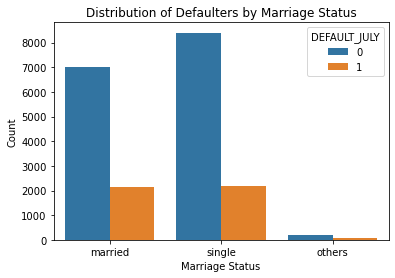

In [126]:
# Create the bar plot
sns.countplot(x="MARRIAGE", hue="DEFAULT_JULY", data=df_married)

# Add labels and title
plt.xlabel("Marriage Status")
plt.ylabel("Count")
plt.title("Distribution of Defaulters by Marriage Status")

# Show the plot
plt.show()

##### Insight: Number of defaulters have a higher proportion of people that are single compared with those that are married or 'other'

##### Effect of Sex

In [127]:
df_sex = train_data[['SEX',"DEFAULT_JULY"]]
df_sex.replace({'SEX' : {1 : 'male', 2 : 'female'}}, inplace = True)

/var/folders/j3/bj_9j1f54xxd2s64s7382plw0000gn/T/ipykernel_1043/1015752371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sex.replace({'SEX' : {1 : 'male', 2 : 'female'}}, inplace = True)


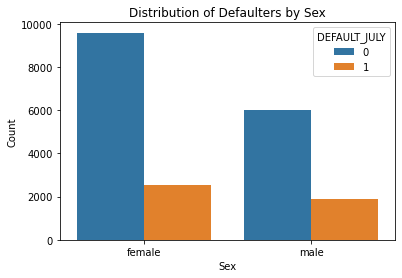

In [128]:
# Create the bar plot
sns.countplot(x="SEX", hue="DEFAULT_JULY", data=df_sex)

# Add labels and title
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Distribution of Defaulters by Sex")

# Show the plot
plt.show()

##### Insight: There are more female carholders than male. Thus there are more defaulters that are women. 

##### Effect of Repayment Status

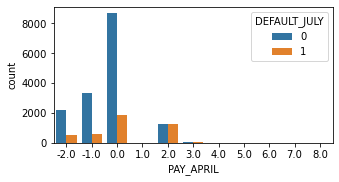

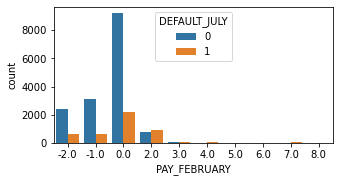

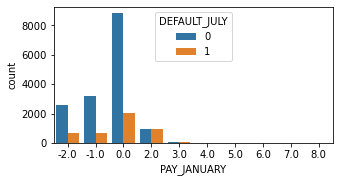

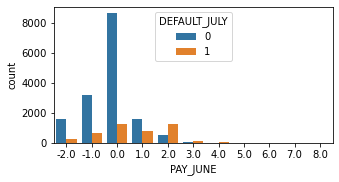

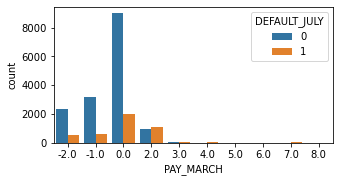

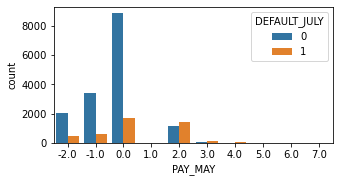

In [129]:
pay_col = ['PAY_APRIL','PAY_FEBRUARY','PAY_JANUARY','PAY_JUNE','PAY_MARCH','PAY_MAY']
for col in pay_col:
  plt.figure(figsize=(5,2.5))
  sns.countplot(x = col, hue = 'DEFAULT_JULY', data = train_data)

##### Insight: It is evident from the above graphs that those with revolving credit consists of the largest number of carholders and maybe that is why also the largest number of defaulters. However it is interesting to see that the second largest category with the most defaulters is 2 which is those that have delayed payment by 2 months. This is significant as the number of non defaulters in this category is almost equal to the defaulters.

## **C. MACHINE LEARNING (5 points)**

### **Question 1**

(1.5 points)

#### Feature Engineering

##### Balance of Dataset

In [130]:
train_data['DEFAULT_JULY'].value_counts()

0    15580
1     4420
Name: DEFAULT_JULY, dtype: int64

As we can see the dataset is quite unbalanced

In [131]:
x = train_data.drop("DEFAULT_JULY",axis=1)
y = train_data["DEFAULT_JULY"]

In [132]:
# Apply SMOTE
smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x, y)

In [133]:
# Check the number of instances in each class
print(y_resampled.value_counts())

0    15580
1    15580
Name: DEFAULT_JULY, dtype: int64


In [134]:
balanced_df = pd.DataFrame(x_resampled)
balanced_df['DEFAULT_JULY']=y_resampled

In [135]:
balanced_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,...,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY
0,9910,130000.0,2,2,1,27,0.0,0.0,0.0,0.0,...,76885.0,81983.0,79106.0,3000.0,3260.0,3200.0,3500.0,3146.0,4000.0,0
1,15561,60000.0,2,3,1,48,-1.0,-1.0,-1.0,-1.0,...,4823.0,4377.0,5471.0,4377.0,2431.0,2120.0,5491.0,3918.0,9683.0,1
2,23607,330000.0,2,1,2,44,2.0,0.0,0.0,0.0,...,243621.0,257535.0,259517.0,9400.0,9766.0,9786.0,21400.0,9542.0,0.0,1
3,6314,60000.0,2,2,2,24,0.0,0.0,0.0,0.0,...,29832.0,15761.0,18628.0,1000.0,1329.0,41378.0,1538.0,118.0,1308.0,0
4,27534,180000.0,2,1,2,33,-1.0,-1.0,-1.0,-2.0,...,4500.0,1500.0,2580.0,1500.0,1118.0,1331.0,2580.0,0.0,178.0,0


/Users/Rad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DEFAULT_JULY', ylabel='count'>

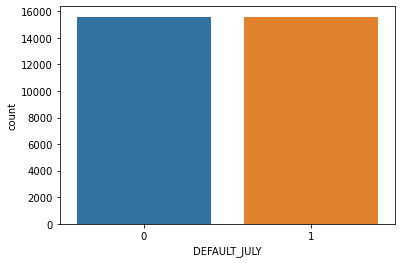

In [136]:
sns.countplot('DEFAULT_JULY', data = balanced_df)

The dataset is successfully balanced

##### The dataset was very unbalanced when it comes to the target variable with the minority being the default category. In this case that is the category of importance to us since we are trying to solve for prediction of credit card defaulters. This could lead to an issue as the model may lead to overall high accuracy but it could be due to high accuracy of the majority category of non-default, but low accuracy for the minority category which is of interest to us. To prevent this we must balance the dataset. In this case I chose to use the oversampling method of SMOTE which is useful when we have limited data for the minority class. The result was a very balanced dataset

In [137]:
#saving a copy of the balanced dataset
df_bal = balanced_df.copy()

##### Encoding

###### One Hot encoding

In [138]:
df_bal.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)
df_bal.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,...,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY
0,9910,130000.0,FEMALE,university,married,27,0.0,0.0,0.0,0.0,...,76885.0,81983.0,79106.0,3000.0,3260.0,3200.0,3500.0,3146.0,4000.0,0
1,15561,60000.0,FEMALE,high school,married,48,-1.0,-1.0,-1.0,-1.0,...,4823.0,4377.0,5471.0,4377.0,2431.0,2120.0,5491.0,3918.0,9683.0,1
2,23607,330000.0,FEMALE,graduate school,single,44,2.0,0.0,0.0,0.0,...,243621.0,257535.0,259517.0,9400.0,9766.0,9786.0,21400.0,9542.0,0.0,1
3,6314,60000.0,FEMALE,university,single,24,0.0,0.0,0.0,0.0,...,29832.0,15761.0,18628.0,1000.0,1329.0,41378.0,1538.0,118.0,1308.0,0
4,27534,180000.0,FEMALE,graduate school,single,33,-1.0,-1.0,-1.0,-2.0,...,4500.0,1500.0,2580.0,1500.0,1118.0,1331.0,2580.0,0.0,178.0,0


In [139]:
df_bal = pd.get_dummies(df_bal,columns=['EDUCATION','MARRIAGE'])
df_bal.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,...,PAY_AMT_MAY,DEFAULT_JULY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,9910,130000.0,FEMALE,27,0.0,0.0,0.0,0.0,0.0,0.0,...,4000.0,0,0,0,0,0,1,1,0,0
1,15561,60000.0,FEMALE,48,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,9683.0,1,0,0,1,0,0,1,0,0
2,23607,330000.0,FEMALE,44,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,1,0,0,0,0,0,1
3,6314,60000.0,FEMALE,24,0.0,0.0,0.0,0.0,0.0,0.0,...,1308.0,0,0,0,0,0,1,0,0,1
4,27534,180000.0,FEMALE,33,-1.0,-1.0,-1.0,-2.0,-1.0,-2.0,...,178.0,0,0,1,0,0,0,0,0,1


In [140]:
df_bal.drop(['EDUCATION_others','MARRIAGE_others'],axis = 1, inplace = True)
df_bal.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,...,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_university,MARRIAGE_married,MARRIAGE_single
0,9910,130000.0,FEMALE,27,0.0,0.0,0.0,0.0,0.0,0.0,...,3500.0,3146.0,4000.0,0,0,0,0,1,1,0
1,15561,60000.0,FEMALE,48,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5491.0,3918.0,9683.0,1,0,0,1,0,1,0
2,23607,330000.0,FEMALE,44,2.0,0.0,0.0,0.0,0.0,0.0,...,21400.0,9542.0,0.0,1,0,1,0,0,0,1
3,6314,60000.0,FEMALE,24,0.0,0.0,0.0,0.0,0.0,0.0,...,1538.0,118.0,1308.0,0,0,0,0,1,0,1
4,27534,180000.0,FEMALE,33,-1.0,-1.0,-1.0,-2.0,-1.0,-2.0,...,2580.0,0.0,178.0,0,0,1,0,0,0,1


In [141]:
df_bal.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_APRIL', 'PAY_FEBRUARY',
       'PAY_JANUARY', 'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY', 'BILL_AMT_APRIL',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'BILL_AMT_JUNE',
       'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'PAY_AMT_APRIL', 'PAY_AMT_FEBRUARY',
       'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH', 'PAY_AMT_MAY',
       'DEFAULT_JULY', 'EDUCATION_5', 'EDUCATION_graduate school',
       'EDUCATION_high school', 'EDUCATION_university', 'MARRIAGE_married',
       'MARRIAGE_single'],
      dtype='object')

###### Label Encoding for Sex

In [142]:
encode_labels = {"SEX":{"FEMALE": 0, "MALE": 1}}
df_bal = df_bal.replace(encode_labels)

In [143]:
df_bal.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,...,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_university,MARRIAGE_married,MARRIAGE_single
0,9910,130000.0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,...,3500.0,3146.0,4000.0,0,0,0,0,1,1,0
1,15561,60000.0,0,48,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5491.0,3918.0,9683.0,1,0,0,1,0,1,0
2,23607,330000.0,0,44,2.0,0.0,0.0,0.0,0.0,0.0,...,21400.0,9542.0,0.0,1,0,1,0,0,0,1
3,6314,60000.0,0,24,0.0,0.0,0.0,0.0,0.0,0.0,...,1538.0,118.0,1308.0,0,0,0,0,1,0,1
4,27534,180000.0,0,33,-1.0,-1.0,-1.0,-2.0,-1.0,-2.0,...,2580.0,0.0,178.0,0,0,1,0,0,0,1


##### Dropping columns

In [144]:
#drop ID
df_bal.drop('ID',axis = 1, inplace = True)

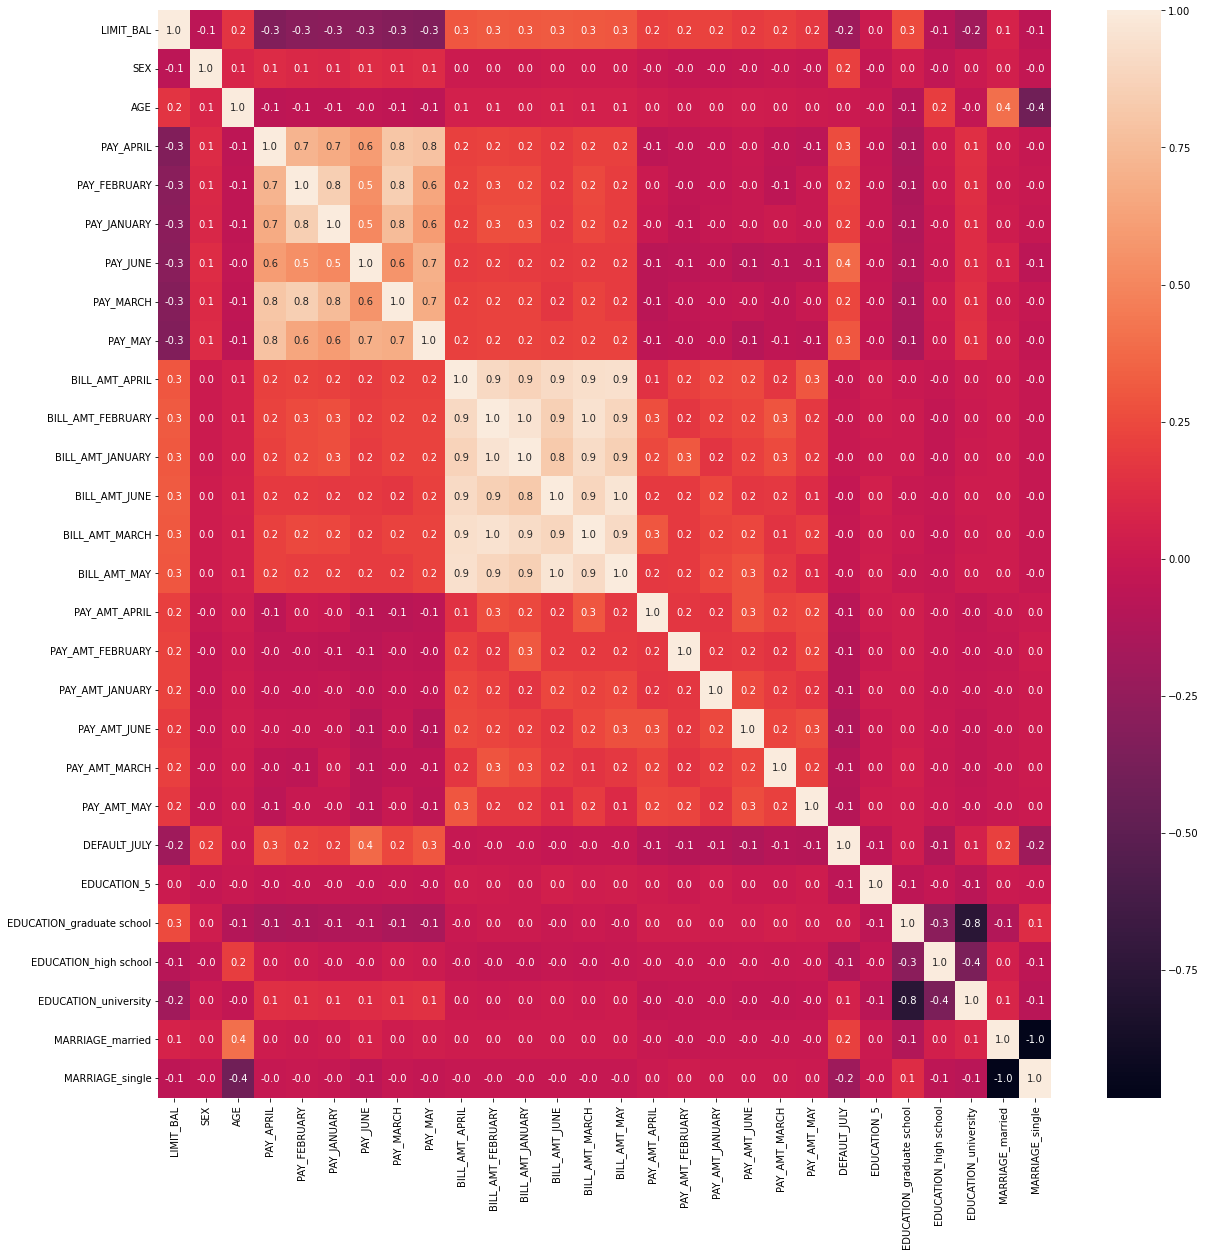

In [146]:
corr = df_bal.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt= ".1f")
plt.show()

df_bal.drop(['PAY_JANUARY','PAY_FEBRUARY','PAY_MARCH','PAY_APRIL','PAY_MAY','BILL_AMT_JANUARY','BILL_AMT_FEBRUARY',BILL_AMT_MARCH,'BILL_AMT_APRIL','BILL_AMT_MAY'],axis = 1, inplace = True)

In [147]:
df_bal.drop(['PAY_JANUARY','PAY_FEBRUARY','PAY_MARCH','PAY_APRIL','PAY_MAY','BILL_AMT_JANUARY','BILL_AMT_FEBRUARY','BILL_AMT_MARCH','BILL_AMT_APRIL','BILL_AMT_MAY', 'EDUCATION_university','MARRIAGE_married'],axis = 1, inplace = True)

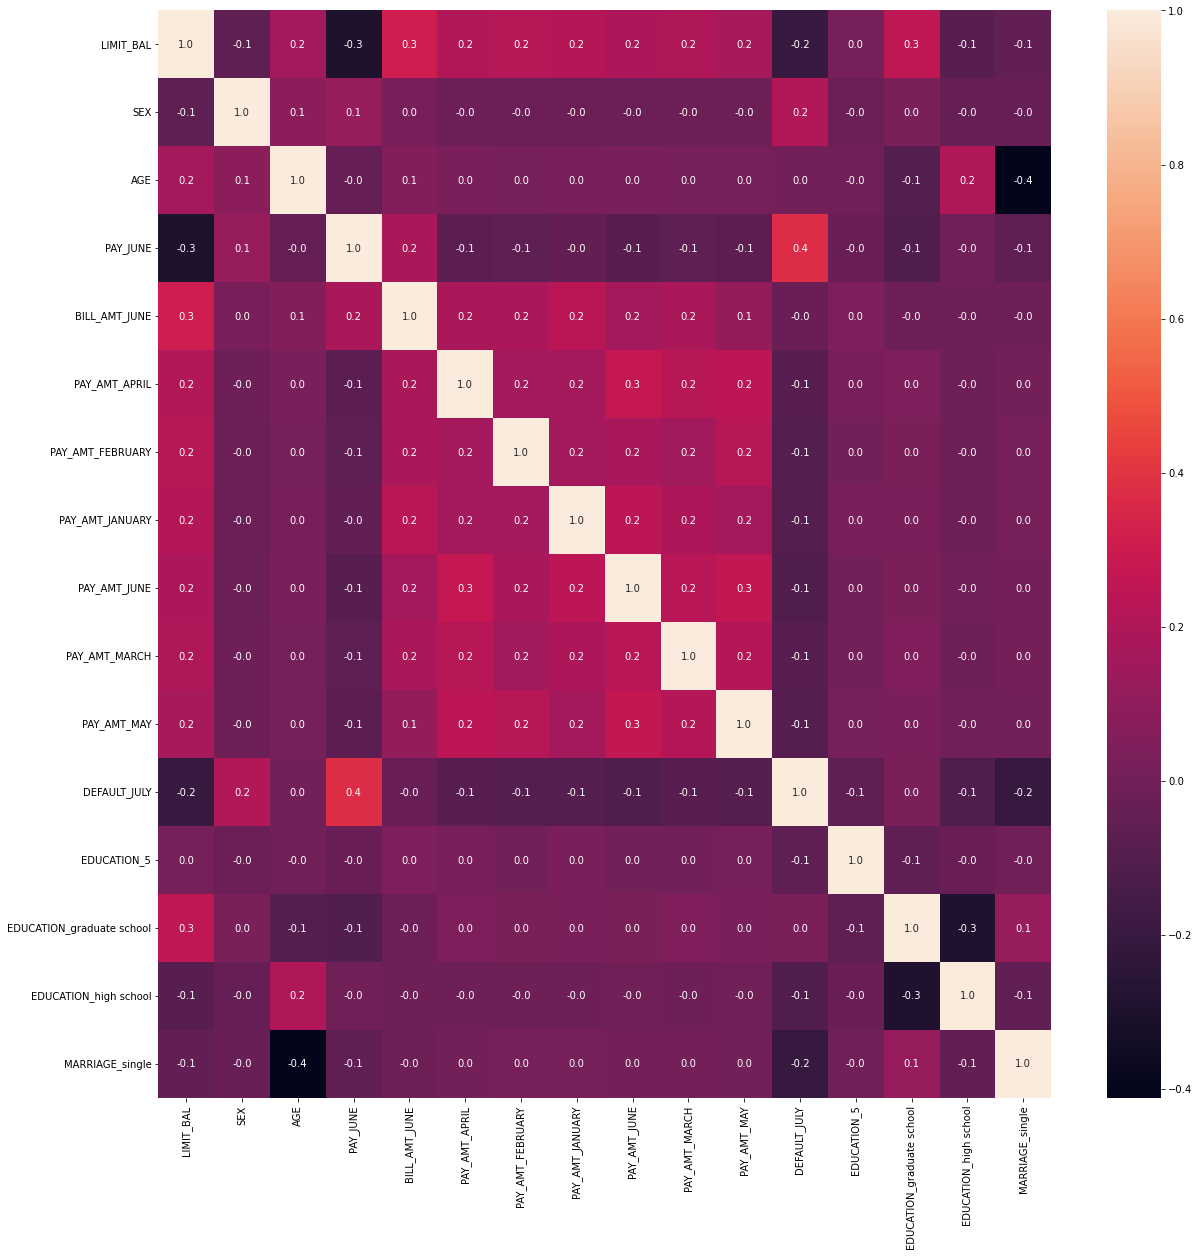

In [148]:
corr = df_bal.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt= ".1f")
plt.show()

#### Training models

##### Train and test split

In [158]:
x = df_bal.drop(["DEFAULT_JULY"],axis=1)
y = df_bal["DEFAULT_JULY"]

In [197]:
numerical_features = list(x.select_dtypes(["int64", "float64"]).columns)
numerical_features

['LIMIT_BAL',
 'SEX',
 'AGE',
 'PAY_JUNE',
 'BILL_AMT_JUNE',
 'PAY_AMT_APRIL',
 'PAY_AMT_FEBRUARY',
 'PAY_AMT_JANUARY',
 'PAY_AMT_JUNE',
 'PAY_AMT_MARCH',
 'PAY_AMT_MAY']

In [202]:
categorical_features = [col for col in x if col not in numerical_features]

In [206]:
preprocessor = ColumnTransformer(transformers=[("num_scl", StandardScaler(), numerical_features)],remainder = "passthrough")

In [207]:
new_col = numerical_features + categorical_features
new_col

['LIMIT_BAL',
 'SEX',
 'AGE',
 'PAY_JUNE',
 'BILL_AMT_JUNE',
 'PAY_AMT_APRIL',
 'PAY_AMT_FEBRUARY',
 'PAY_AMT_JANUARY',
 'PAY_AMT_JUNE',
 'PAY_AMT_MARCH',
 'PAY_AMT_MAY',
 'EDUCATION_5',
 'EDUCATION_graduate school',
 'EDUCATION_high school',
 'MARRIAGE_single']

In [214]:
x_train_processed = pd.DataFrame(preprocessor.fit_transform(x), columns= new_col)
x_train_processed = x_train_processed.astype("float64") 
x_train_processed

,LIMIT_BAL,SEX,AGE,PAY_JUNE,BILL_AMT_JUNE,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,MARRIAGE_single
0,-0.187367,-0.978976,-0.959193,-0.196857,0.364927,-0.091504,-0.055631,-0.072855,-0.087373,-0.073393,-0.041104,0.0,0.0,0.0,0.0
1,-0.746262,-0.978976,1.422837,-1.030979,-0.615049,-0.007102,-0.118057,-0.148072,0.051943,-0.017682,0.256799,0.0,0.0,1.0,0.0
2,1.409477,-0.978976,0.969117,-0.196857,2.632380,0.300775,0.434286,0.385833,1.165143,0.388177,-0.250785,0.0,1.0,0.0,1.0
3,-0.746262,-0.978976,-1.299483,-0.196857,-0.274950,-0.214091,-0.201040,2.586084,-0.224660,-0.291910,-0.182219,0.0,0.0,0.0,1.0
4,0.211844,-0.978976,-0.278613,-1.865101,-0.619442,-0.183444,-0.216929,-0.203023,-0.151748,-0.300426,-0.241454,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31155,-0.985788,-0.978976,-0.165183,1.383514,-0.310272,-0.217319,-0.152624,-0.295721,-0.324907,-0.296625,-0.146497,0.0,0.0,0.0,0.0
31156,-1.065631,1.021476,1.195977,2.705629,-0.405946,-0.251595,-0.268823,-0.274196,-0.279654,-0.273718,-0.213168,0.0,0.0,0.0,1.0
31157,-1.065631,1.021476,-0.051753,0.535612,-0.601140,-0.213728,-0.279076,-0.251641,-0.269623,-0.252191,-0.159046,0.0,1.0,0.0,0.0
31158,-0.826104,1.021476,-1.412913,1.471386,-0.007549,-0.157216,-0.181983,-0.223290,-0.242674,-0.216635,-0.136647,0.0,1.0,0.0,1.0


##### Models

In [244]:
param_grid_rfc = {
    'n_estimators' : [25, 50, 100, 150, 500],
    'max_depth' : [2, 5, 10, 50],
    'bootstrap' : [True, False],
}

param_grid_clf = {
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [3, 5],
    'n_estimators': [100,200, 500],
}

###### Random Forest

In [237]:
rfc = RandomForestClassifier()


In [272]:
grid_search_rfc = GridSearchCV(estimator = rfc , param_grid = param_grid_rfc, cv = 3, verbose = 1,scoring = "roc_auc", n_jobs=-1)    
grid_search_rfc.fit(x_train_processed, y)

print(f"Best hyperparameters: {grid_search_rfc.best_params_}")
print(f"Best score: {grid_search_rfc.best_score_}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 50, 'n_estimators': 500}
Best score: 0.9153419241166798


###### XgBoost

In [241]:
clf = xgb.XGBClassifier()

In [273]:
grid_search_xg = GridSearchCV(estimator = clf , param_grid = param_grid_clf, cv = 3, verbose = 1,scoring = "roc_auc", n_jobs=-1)    
grid_search_xg.fit(x_train_processed, y)

print(f"Best hyperparameters: {grid_search_xg.best_params_}")
print(f"Best score: {grid_search_xg.best_score_}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
Best score: 0.888602259798103


##### Test data

In [247]:
test_data = pd.read_csv("Data/test_data.csv")
test_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,DEFAULT_JULY
0,11316,170000.0,1,2,2,36,-2,-2,-2,-2,...,1340.0,0.0,0.0,1598.0,0.0,1340.0,0.0,0.0,3200.0,0
1,26420,120000.0,1,2,2,25,0,0,2,0,...,3345.0,2929.0,2520.0,2446.0,438.0,1000.0,0.0,7.0,0.0,0
2,7847,250000.0,2,1,2,38,-1,-1,-1,-1,...,15410.0,1276.0,0.0,990.0,8150.0,15410.0,1276.0,0.0,0.0,0
3,8083,100000.0,1,1,1,55,0,0,0,0,...,17158.0,18758.0,17168.0,8000.0,2000.0,4000.0,2000.0,3000.0,0.0,0
4,7455,30000.0,1,1,2,56,2,0,0,0,...,29313.0,29019.0,28916.0,1480.0,1448.0,1021.0,1040.0,1216.0,1270.0,0


In [248]:
test_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY',
       'DEFAULT_JULY'],
      dtype='object')

In [260]:
test_data.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)
test_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,DEFAULT_JULY
0,11316,170000.0,MALE,university,single,36,-2,-2,-2,-2,...,1340.0,0.0,0.0,1598.0,0.0,1340.0,0.0,0.0,3200.0,0
1,26420,120000.0,MALE,university,single,25,0,0,2,0,...,3345.0,2929.0,2520.0,2446.0,438.0,1000.0,0.0,7.0,0.0,0
2,7847,250000.0,FEMALE,graduate school,single,38,-1,-1,-1,-1,...,15410.0,1276.0,0.0,990.0,8150.0,15410.0,1276.0,0.0,0.0,0
3,8083,100000.0,MALE,graduate school,married,55,0,0,0,0,...,17158.0,18758.0,17168.0,8000.0,2000.0,4000.0,2000.0,3000.0,0.0,0
4,7455,30000.0,MALE,graduate school,single,56,2,0,0,0,...,29313.0,29019.0,28916.0,1480.0,1448.0,1021.0,1040.0,1216.0,1270.0,0


In [261]:
test_data = pd.get_dummies(test_data,columns=['EDUCATION','MARRIAGE'])
test_data.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,PAY_FEBRUARY,PAY_JANUARY,...,EDUCATION_5,EDUCATION_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_0,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,11316,170000.0,MALE,36,-2,-2,-2,-2,-2,-2,...,0,0,0,0,0,1,0,0,0,1
1,26420,120000.0,MALE,25,0,0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,7847,250000.0,FEMALE,38,-1,-1,-1,-1,-1,-1,...,0,0,1,0,0,0,0,0,0,1
3,8083,100000.0,MALE,55,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,7455,30000.0,MALE,56,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [262]:
test_data.drop(['EDUCATION_others','MARRIAGE_others'],axis = 1, inplace = True)
test_data.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,PAY_FEBRUARY,PAY_JANUARY,...,DEFAULT_JULY,EDUCATION_0,EDUCATION_5,EDUCATION_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_university,MARRIAGE_0,MARRIAGE_married,MARRIAGE_single
0,11316,170000.0,MALE,36,-2,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,1,0,0,1
1,26420,120000.0,MALE,25,0,0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,7847,250000.0,FEMALE,38,-1,-1,-1,-1,-1,-1,...,0,0,0,0,1,0,0,0,0,1
3,8083,100000.0,MALE,55,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,7455,30000.0,MALE,56,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [264]:
encode_labels = {"SEX":{"FEMALE": 0, "MALE": 1}}
test_data = test_data.replace(encode_labels)

In [265]:
test_data.drop(['PAY_JANUARY','PAY_FEBRUARY','PAY_MARCH','PAY_APRIL','PAY_MAY','BILL_AMT_JANUARY','BILL_AMT_FEBRUARY','BILL_AMT_MARCH','BILL_AMT_APRIL','BILL_AMT_MAY', 'EDUCATION_university','MARRIAGE_married'],axis = 1, inplace = True)

In [269]:
x_test = test_data.drop(columns = ["ID", "DEFAULT_JULY"])
y_test = test_data["DEFAULT_JULY"]

In [271]:
x_test_processed = pd.DataFrame(preprocessor.transform(x_test), columns= new_col)
x_test_processed

,LIMIT_BAL,SEX,AGE,PAY_JUNE,BILL_AMT_JUNE,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,MARRIAGE_single
0,0.132002,1.021476,0.061677,-1.865101,-0.672478,-0.193251,-0.301117,-0.072855,-0.220462,-0.300426,-0.250785,0.0,0.0,0.0,1.0
1,-0.267209,1.021476,-1.186053,-0.196857,-0.529049,-0.214091,-0.300590,-0.295721,-0.161125,-0.300426,-0.227825,0.0,0.0,0.0,1.0
2,0.770739,-0.978976,0.288537,-1.030979,-0.479834,0.669150,-0.301117,-0.295721,-0.263005,-0.208343,0.176439,0.0,1.0,0.0,1.0
3,-0.426893,1.021476,2.216847,-0.196857,-0.534964,-0.030210,-0.075210,-0.295721,0.227505,-0.156095,-0.145945,0.0,1.0,0.0,0.0
4,-0.985788,1.021476,2.330277,1.471386,-0.313014,-0.212804,-0.209550,-0.207271,-0.228718,-0.225374,-0.174880,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1.329635,1.021476,-0.392043,-1.030979,-0.593019,1.551839,-0.121446,-0.263545,-0.300721,1.142883,-0.250785,0.0,0.0,0.0,0.0
8996,-0.826104,1.021476,1.422837,1.471386,-0.097918,-0.214091,-0.173103,0.017685,-0.262305,-0.228261,-0.046346,0.0,0.0,0.0,0.0
8997,-0.267209,-0.978976,-0.392043,-0.196857,-0.610575,-0.220833,-0.301117,-0.185681,-0.261256,-0.081043,-0.204131,0.0,0.0,1.0,1.0
8998,1.010266,1.021476,0.742257,-0.196857,-0.422827,0.097526,0.047307,-0.045762,-0.145031,0.117989,9.686484,0.0,1.0,0.0,0.0


In [274]:
predicted = grid_search_rfc.predict_proba(x_test_processed)
predicted = pd.Series(predicted[:,1], name = "Default")
predicted

0       0.168
1       0.368
2       0.144
3       0.168
4       0.440
        ...  
8995    0.206
8996    0.840
8997    0.174
8998    0.208
8999    0.430
Name: Default, Length: 9000, dtype: float64

In [276]:
roc_score = roc_auc_score(y_test, predicted)
print(roc_score)

0.7437084145052137


##### Submission Set

In [279]:
sub_set = pd.read_csv("Data/submission_features.csv")
sub_set.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY',
       'PAY_AMT_JANUARY'],
      dtype='object')

In [281]:
sub_set.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)
sub_set.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_APRIL,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY
0,2774,70000.0,FEMALE,high school,single,22,0,0,0,0,...,37858.0,29660.0,29519.0,29457.0,1726.0,3028.0,1026.0,1195.0,1060.0,1031.0
1,15339,100000.0,FEMALE,university,married,38,1,2,0,0,...,15323.0,16268.0,15868.0,16448.0,0.0,1600.0,1500.0,0.0,1000.0,1500.0
2,26485,140000.0,FEMALE,graduate school,single,40,1,2,0,0,...,128285.0,123074.0,97382.0,99364.0,0.0,6601.0,5522.0,3200.0,3300.0,3500.0
3,6657,380000.0,FEMALE,university,single,27,0,0,-1,0,...,270219.0,3641.0,3717.0,3791.0,0.0,270219.0,131.0,135.0,136.0,76.0
4,7917,100000.0,MALE,university,single,26,0,0,0,0,...,33680.0,34419.0,37782.0,76185.0,2000.0,2000.0,2000.0,4500.0,40000.0,3000.0


In [283]:
sub_set = pd.get_dummies(sub_set,columns=['EDUCATION','MARRIAGE'])
sub_set.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,PAY_FEBRUARY,PAY_JANUARY,...,EDUCATION_5,EDUCATION_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university,MARRIAGE_0,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,2774,70000.0,FEMALE,22,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,15339,100000.0,FEMALE,38,1,2,0,0,2,0,...,0,0,0,0,0,1,0,1,0,0
2,26485,140000.0,FEMALE,40,1,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,6657,380000.0,FEMALE,27,0,0,-1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,7917,100000.0,MALE,26,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [284]:
sub_set.drop(['EDUCATION_others','MARRIAGE_others'],axis = 1, inplace = True)
sub_set.head()

,ID,LIMIT_BAL,SEX,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,PAY_FEBRUARY,PAY_JANUARY,...,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,EDUCATION_5,EDUCATION_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_university,MARRIAGE_0,MARRIAGE_married,MARRIAGE_single
0,2774,70000.0,FEMALE,22,0,0,0,0,0,0,...,1060.0,1031.0,0,0,0,1,0,0,0,1
1,15339,100000.0,FEMALE,38,1,2,0,0,2,0,...,1000.0,1500.0,0,0,0,0,1,0,1,0
2,26485,140000.0,FEMALE,40,1,2,0,0,0,0,...,3300.0,3500.0,0,0,1,0,0,0,0,1
3,6657,380000.0,FEMALE,27,0,0,-1,0,0,0,...,136.0,76.0,0,0,0,0,1,0,0,1
4,7917,100000.0,MALE,26,0,0,0,0,0,0,...,40000.0,3000.0,0,0,0,0,1,0,0,1


In [285]:
encode_labels = {"SEX":{"FEMALE": 0, "MALE": 1}}
sub_set = sub_set.replace(encode_labels)

In [286]:
sub_set.drop(['PAY_JANUARY','PAY_FEBRUARY','PAY_MARCH','PAY_APRIL','PAY_MAY','BILL_AMT_JANUARY','BILL_AMT_FEBRUARY','BILL_AMT_MARCH','BILL_AMT_APRIL','BILL_AMT_MAY', 'EDUCATION_university','MARRIAGE_married'],axis = 1, inplace = True)

In [298]:
sub_set_processed = pd.DataFrame(preprocessor.transform(sub_set), columns= new_col)
sub_set_processed

,LIMIT_BAL,SEX,AGE,PAY_JUNE,BILL_AMT_JUNE,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,EDUCATION_5,EDUCATION_graduate school,EDUCATION_high school,MARRIAGE_single
0,-0.666420,-0.978976,-1.526343,-0.196857,0.038739,-0.212497,-0.221297,-0.223917,-0.211505,-0.214188,-0.092057,0.0,0.0,1.0,1.0
1,-0.426893,-0.978976,0.288537,0.637264,-0.483682,-0.183444,-0.225815,-0.191253,-0.332278,-0.300426,-0.166913,0.0,0.0,0.0,0.0
2,-0.107524,-0.978976,0.515397,0.637264,1.270529,0.063079,-0.052619,-0.051961,-0.332278,-0.069497,0.095240,0.0,1.0,0.0,1.0
3,1.808688,-0.978976,-0.959193,-0.196857,-0.620802,-0.267355,-0.290876,-0.290428,-0.332278,-0.290684,13.914108,0.0,0.0,0.0,1.0
4,-0.426893,1.021476,-1.072623,-0.196857,-0.242938,-0.152797,2.710981,-0.086784,-0.192332,0.024319,-0.145945,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.010266,1.021476,-0.845763,-0.196857,1.219410,-0.030210,-0.075210,-0.226076,0.087559,-0.011764,-0.041104,0.0,1.0,0.0,1.0
996,0.211844,1.021476,1.422837,-1.030979,-0.663040,-0.196071,-0.281238,-0.277335,-0.241733,-0.132713,-0.173937,0.0,0.0,0.0,0.0
997,-0.506735,-0.978976,-0.392043,0.637264,-0.680638,-0.120925,-0.301117,-0.295721,-0.309677,-0.181281,-0.250785,0.0,0.0,0.0,0.0
998,-0.746262,-0.978976,-0.845763,1.471386,-0.023504,-0.152797,0.001523,-0.295721,-0.003965,-0.300426,-0.119735,0.0,0.0,0.0,1.0


In [299]:
predicted_sub = grid_search_rfc.predict_proba(sub_set_processed)
predicted_sub = pd.Series(predicted_sub[:,1], name = "DEFAULT_PROBA")
predicted_sub

0      0.142
1      0.612
2      0.194
3      0.220
4      0.092
       ...  
995    0.068
996    0.590
997    0.160
998    0.758
999    0.110
Name: DEFAULT_PROBA, Length: 1000, dtype: float64

In [300]:
submission_final = pd.concat([sub_set["ID"], predicted_sub], axis = 1)
submission_final["DEFAULT_PROBA"].value_counts()

0.124    11
0.196    10
0.164    10
0.216     9
0.066     9
         ..
0.934     1
0.616     1
0.018     1
0.000     1
0.758     1
Name: DEFAULT_PROBA, Length: 358, dtype: int64

In [301]:
submission_final.to_csv("Patel_Radhika_C1_submission.csv")

In [302]:
submission_final.head()

,ID,DEFAULT_PROBA
0,2774,0.142
1,15339,0.612
2,26485,0.194
3,6657,0.220
4,7917,0.092


In [303]:
submission_final.isnull().sum()

ID               0
DEFAULT_PROBA    0
dtype: int64

### **Question 2**

(1 points)

In [304]:
submission_final.sort_values("DEFAULT_PROBA", ascending = True).head()

,ID,DEFAULT_PROBA
346,29679,0.000
909,27080,0.002
889,17142,0.004
914,26872,0.006
142,23792,0.006


### **Question 3**

(2.5 points)

In [310]:
threshold = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

tpl = []
fpl = []
tnl = []
fnl = []

In [311]:
for t in threshold:
    tresh_pred = (predicted >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, tresh_pred).ravel()
    tpl.append(tp)
    fpl.append(fp)
    tnl.append(tn)
    fnl.append(fn)

In [313]:
print(tpl)
print(fpl)
print(tnl)
print(fnl)

[1897, 1758, 1592, 1424, 1293, 1182, 1059, 956, 875, 784, 689, 576, 483, 385, 281, 172]
[5642, 4567, 3518, 2648, 2033, 1537, 1190, 926, 733, 569, 444, 334, 253, 171, 115, 74]
[1363, 2438, 3487, 4357, 4972, 5468, 5815, 6079, 6272, 6436, 6561, 6671, 6752, 6834, 6890, 6931]
[98, 237, 403, 571, 702, 813, 936, 1039, 1120, 1211, 1306, 1419, 1512, 1610, 1714, 1823]


In [318]:
threshholds_df= pd.DataFrame({'THRESHOLDS': threshold,'TPos' : tpl,'FPos': fpl,'TNeg': tnl,'FNeg': fnl}) 

In [320]:
#def adding_rows(row):
    #return row.TPos + row.FPos+ row.TNeg + row.FNeg

In [326]:
threshholds_df["Total"]=threshholds_df.apply(lambda row: row.TPos +row.FPos+row.TNeg +row.FNeg,axis=1)
threshholds_df["Profit"]=threshholds_df.apply(lambda row: (0*row.TPos) +(0*row.FPos) +(1000*row.TNeg) +(-5000*row.FNeg), axis=1)
threshholds_df.head()

,THRESHOLDS,TPos,FPos,TNeg,FNeg,Total,Profit
0,0.10,1897,5642,1363,98,9000.0,873000.0
1,0.15,1758,4567,2438,237,9000.0,1253000.0
2,0.20,1592,3518,3487,403,9000.0,1472000.0
3,0.25,1424,2648,4357,571,9000.0,1502000.0
4,0.30,1293,2033,4972,702,9000.0,1462000.0


In [323]:
threshholds_df['Profit'].max()

1502000.0

In [325]:
threshholds_df.loc[threshholds_df['Profit']==1502000.0]

,THRESHOLDS,TPos,FPos,TNeg,FNeg,Total,Profit
3,0.25,1424,2648,4357,571,9000.0,1502000.0


Threshhold = 0.25
Profit = 1502000.0